# Initializing Hydrological Models in CONFLUENCE

## Introduction

This notebook guides you through the process of initializing hydrological models within the CONFLUENCE framework. Model initialization is a critical step that sets up the model structure, parameters, and initial conditions for simulation.

Key steps covered in this notebook include:

1. Performing initial test runs to ensure proper setup.
2. Vizualise initial output.

In this notebook we focus on initializing the primary model chosen for your project, but the principles can be applied to other  models as well. By the end of this notebook, your model will be fully initialized and running.

## First we import the libraries and functions we need

In [1]:
import sys
from pathlib import Path
from typing import Dict, Any
import logging
import yaml # type: ignore

current_dir = Path.cwd()
parent_dir = current_dir.parent.parent
sys.path.append(str(parent_dir))

from utils.models_utils.model_utils import SummaRunner, MizuRouteRunner # type: ignore
from utils.report_utils.reporting_utils import VisualizationReporter

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

## Check configurations

Now we should print our configuration settings and make sure that we have defined all the settings we need. 

In [2]:
config_path = Path('../../0_config_files/config_active.yaml')
with open(config_path, 'r') as config_file:
    config = yaml.safe_load(config_file)
    print(f"FORCING_DATASET: {config['FORCING_DATASET']}")
    print(f"EASYMORE_CLIENT: {config['EASYMORE_CLIENT']}")
    print(f"FORCING_VARIABLES: {config['FORCING_VARIABLES']}")
    print(f"EXPERIMENT_TIME_START: {config['EXPERIMENT_TIME_START']}")
    print(f"EXPERIMENT_TIME_END: {config['EXPERIMENT_TIME_END']}")

FORCING_DATASET: ERA5
EASYMORE_CLIENT: easymore cli
FORCING_VARIABLES: longitude,latitude,time,LWRadAtm,SWRadAtm,pptrate,airpres,airtemp,spechum,windspd
EXPERIMENT_TIME_START: 2008-01-01 00:00
EXPERIMENT_TIME_END: 2022-12-31 23:00


## Define default paths

Now let's define the paths to data directories before we run the pre processing scripts and create the containing directories

In [3]:
# Main project directory
data_dir = config['CONFLUENCE_DATA_DIR']
project_dir = Path(data_dir) / f"domain_{config['DOMAIN_NAME']}"

# Data directoris
simulation_dir = project_dir / 'simulations' / f"{config['EXPERIMENT_ID']}"
hydro_model_dir = simulation_dir / f"{config['HYDROLOGICAL_MODEL']}"
routing_model_dir = simulation_dir / f"{config['ROUTING_MODEL']}"

# Make sure the new directories exists
hydro_model_dir.mkdir(parents = True, exist_ok = True)
routing_model_dir.mkdir(parents = True, exist_ok = True)

## 1. Initalize hydrological model runs

In [4]:
# Initialize model specific preprocessors
if config['HYDROLOGICAL_MODEL'] == 'SUMMA':
    sr = SummaRunner(config, logger)
    spatial_results = sr.run_summa()
    if config['DOMAIN_DEFINITION_METHOD'] != 'lumped': # lumped domain definition has no routing
        mr = MizuRouteRunner(config, logger)
        streamflow_results = mr.run_mizuroute()

2025-04-07 18:08:29,169 - INFO - Starting SUMMA run
2025-04-07 18:12:45,666 - INFO - SUMMA run completed successfully


## 2. Visualize results

2025-04-07 18:22:49,737 - INFO - Streamflow comparison plot saved to: /Users/amedin/Research/Confluence/CONFLUENCE_data/domain_Wolverine/plots/results/streamflow_comparison.png


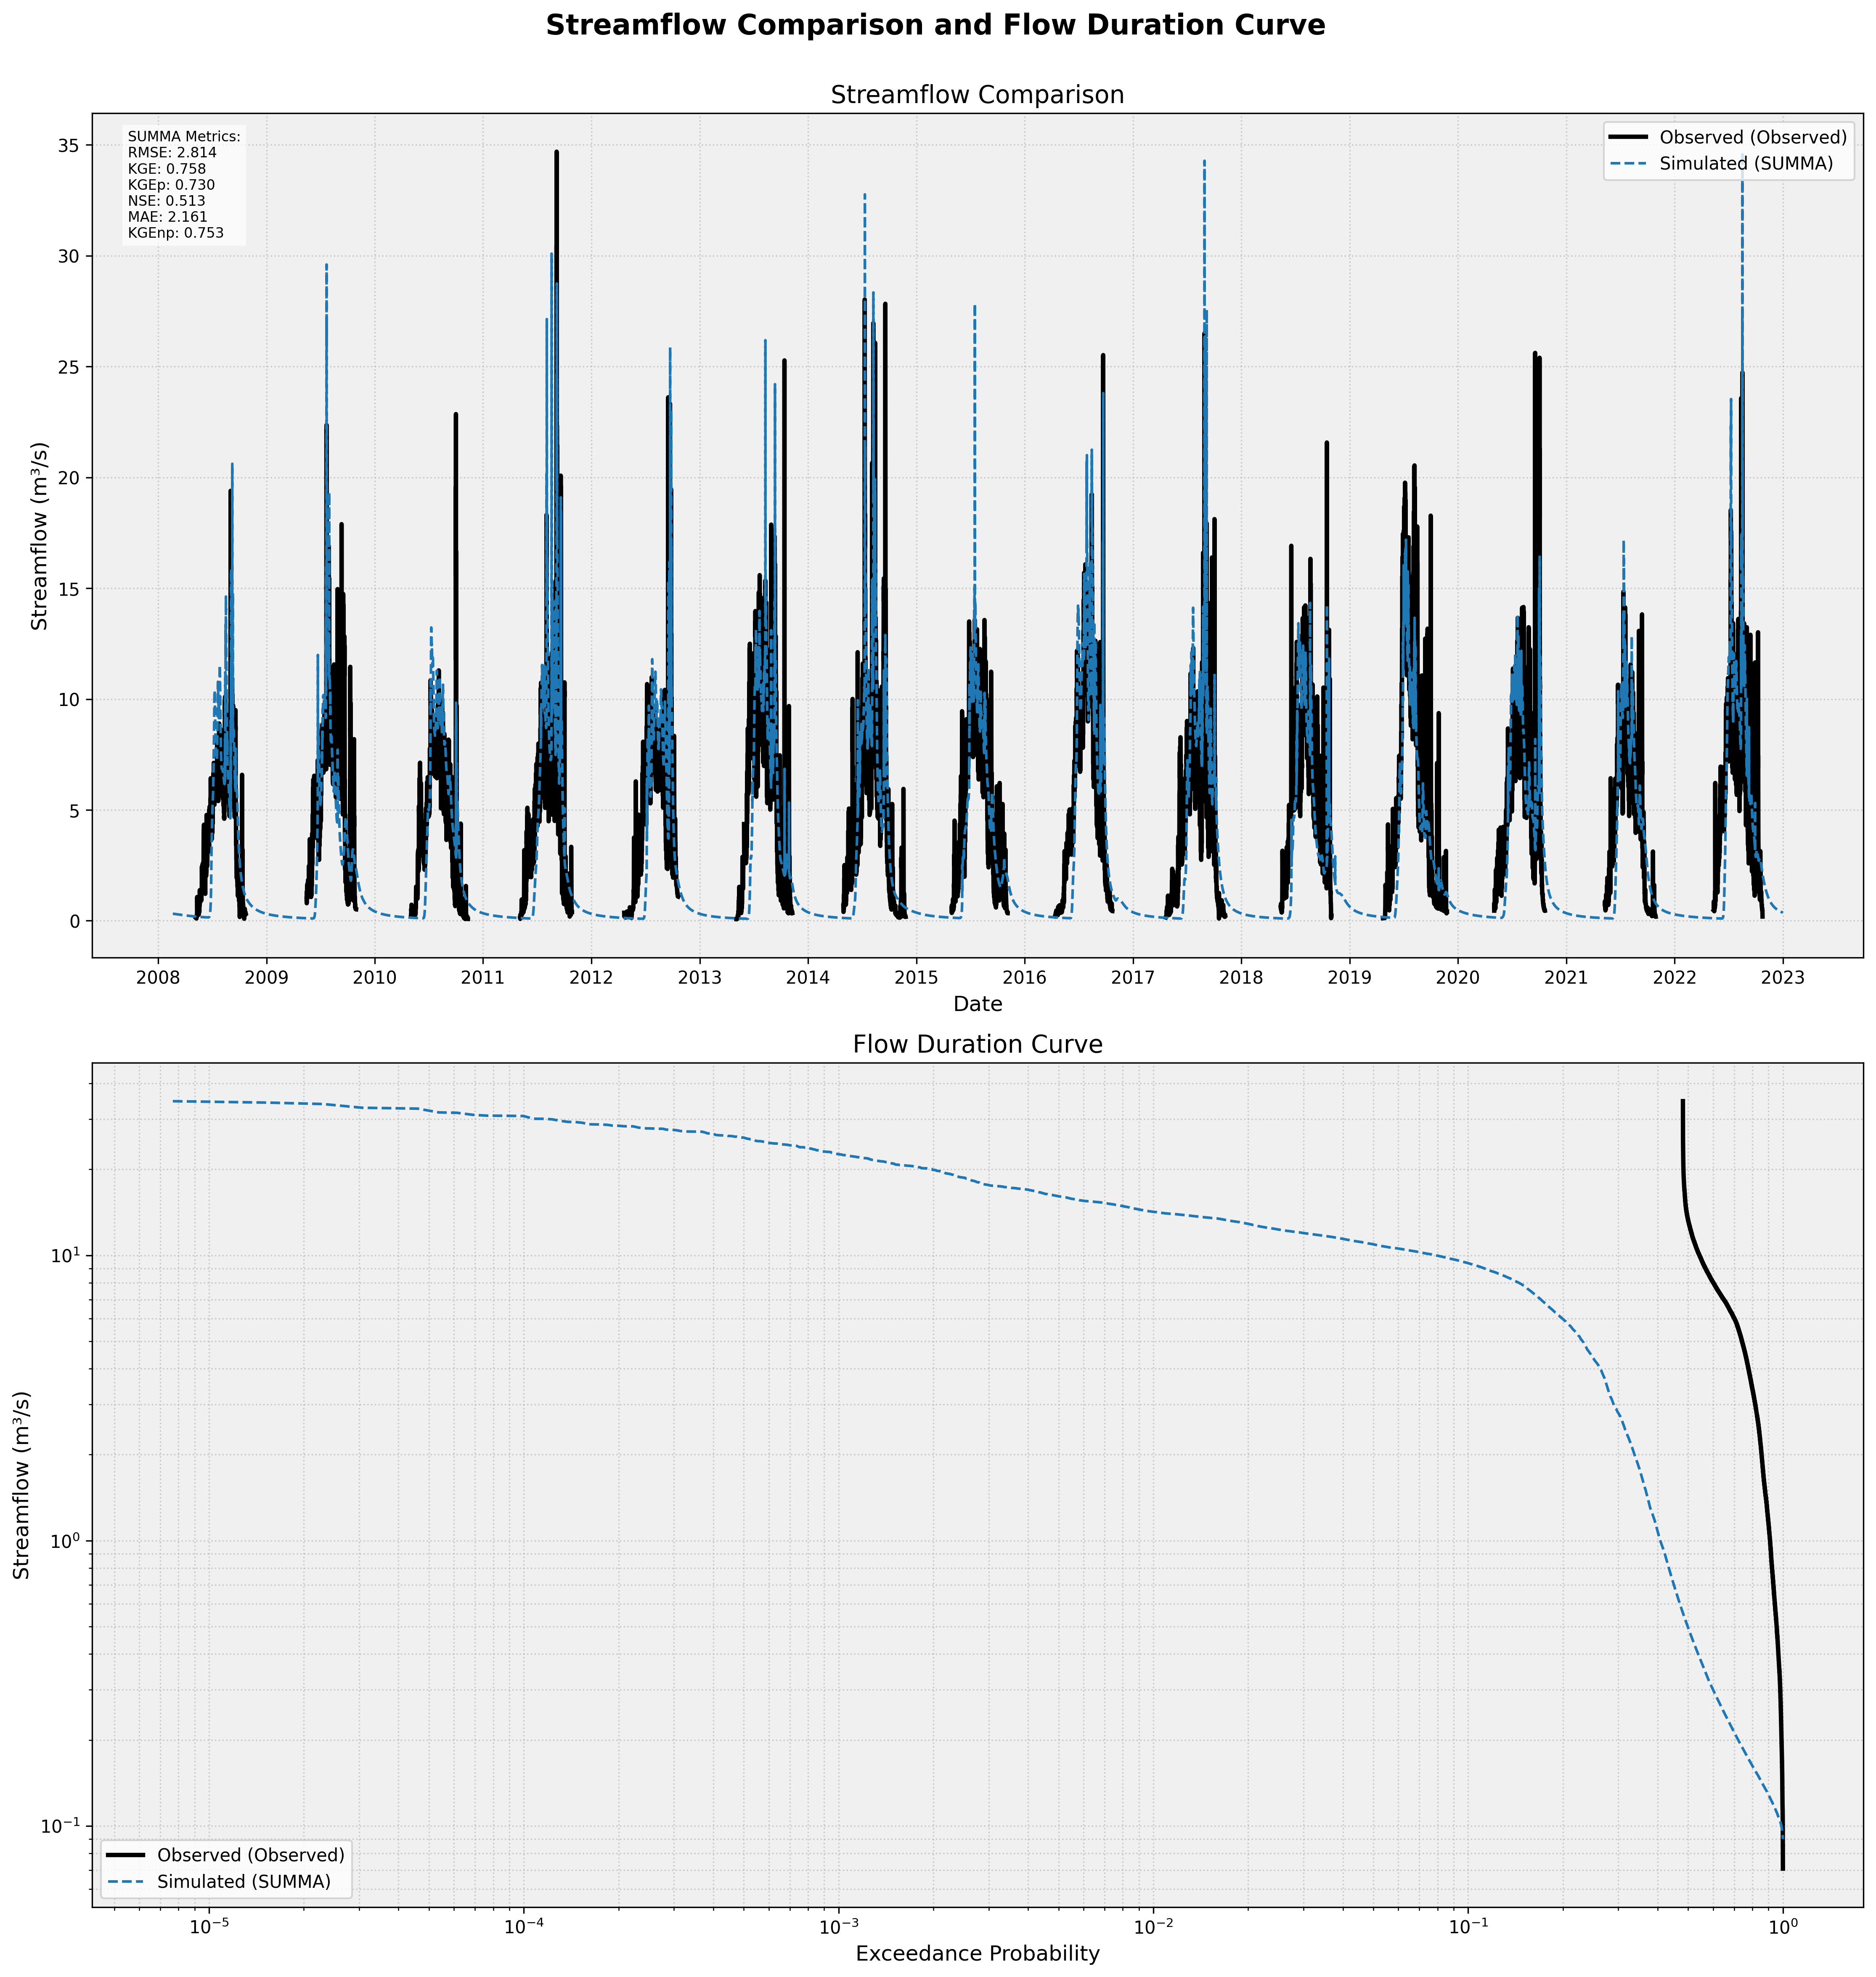

In [7]:
# Initialize time series visualizer
vr = VisualizationReporter(config, logger)

# Create visualization
if config['DOMAIN_DEFINITION_METHOD'] != 'lumped':
    model_outputs = [(f"{config['HYDROLOGICAL_MODEL']}", str(project_dir / "simulations" / config['EXPERIMENT_ID'] / "mizuRoute" / f"{config['EXPERIMENT_ID']}.nc"))]
else: # lumped domain definition has no routing
    model_outputs = [(f"{config['HYDROLOGICAL_MODEL']}", str(project_dir / "simulations" / config['EXPERIMENT_ID'] / config['HYDROLOGICAL_MODEL'] / f"{config['EXPERIMENT_ID']}_timestep.nc"))]
obs_files = [('Observed', str(project_dir / "observations" / "streamflow" / "preprocessed" / f"{config.get('DOMAIN_NAME')}_streamflow_processed.csv"))]
plot_file = vr.plot_streamflow_simulations_vs_observations(model_outputs, obs_files)

if plot_file:
    logger.info(f"Streamflow comparison plot saved to: {plot_file}")
else:
    logger.error("Failed to create streamflow comparison plot")

# Optional: Display the plot in the notebook
from IPython.display import Image
Image(filename=plot_file)


2025-04-07 18:22:10,185 - INFO - Streamflow comparison plot saved to: /Users/amedin/Research/Confluence/CONFLUENCE_data/domain_Wolverine/plots/results/streamflow_comparison.png


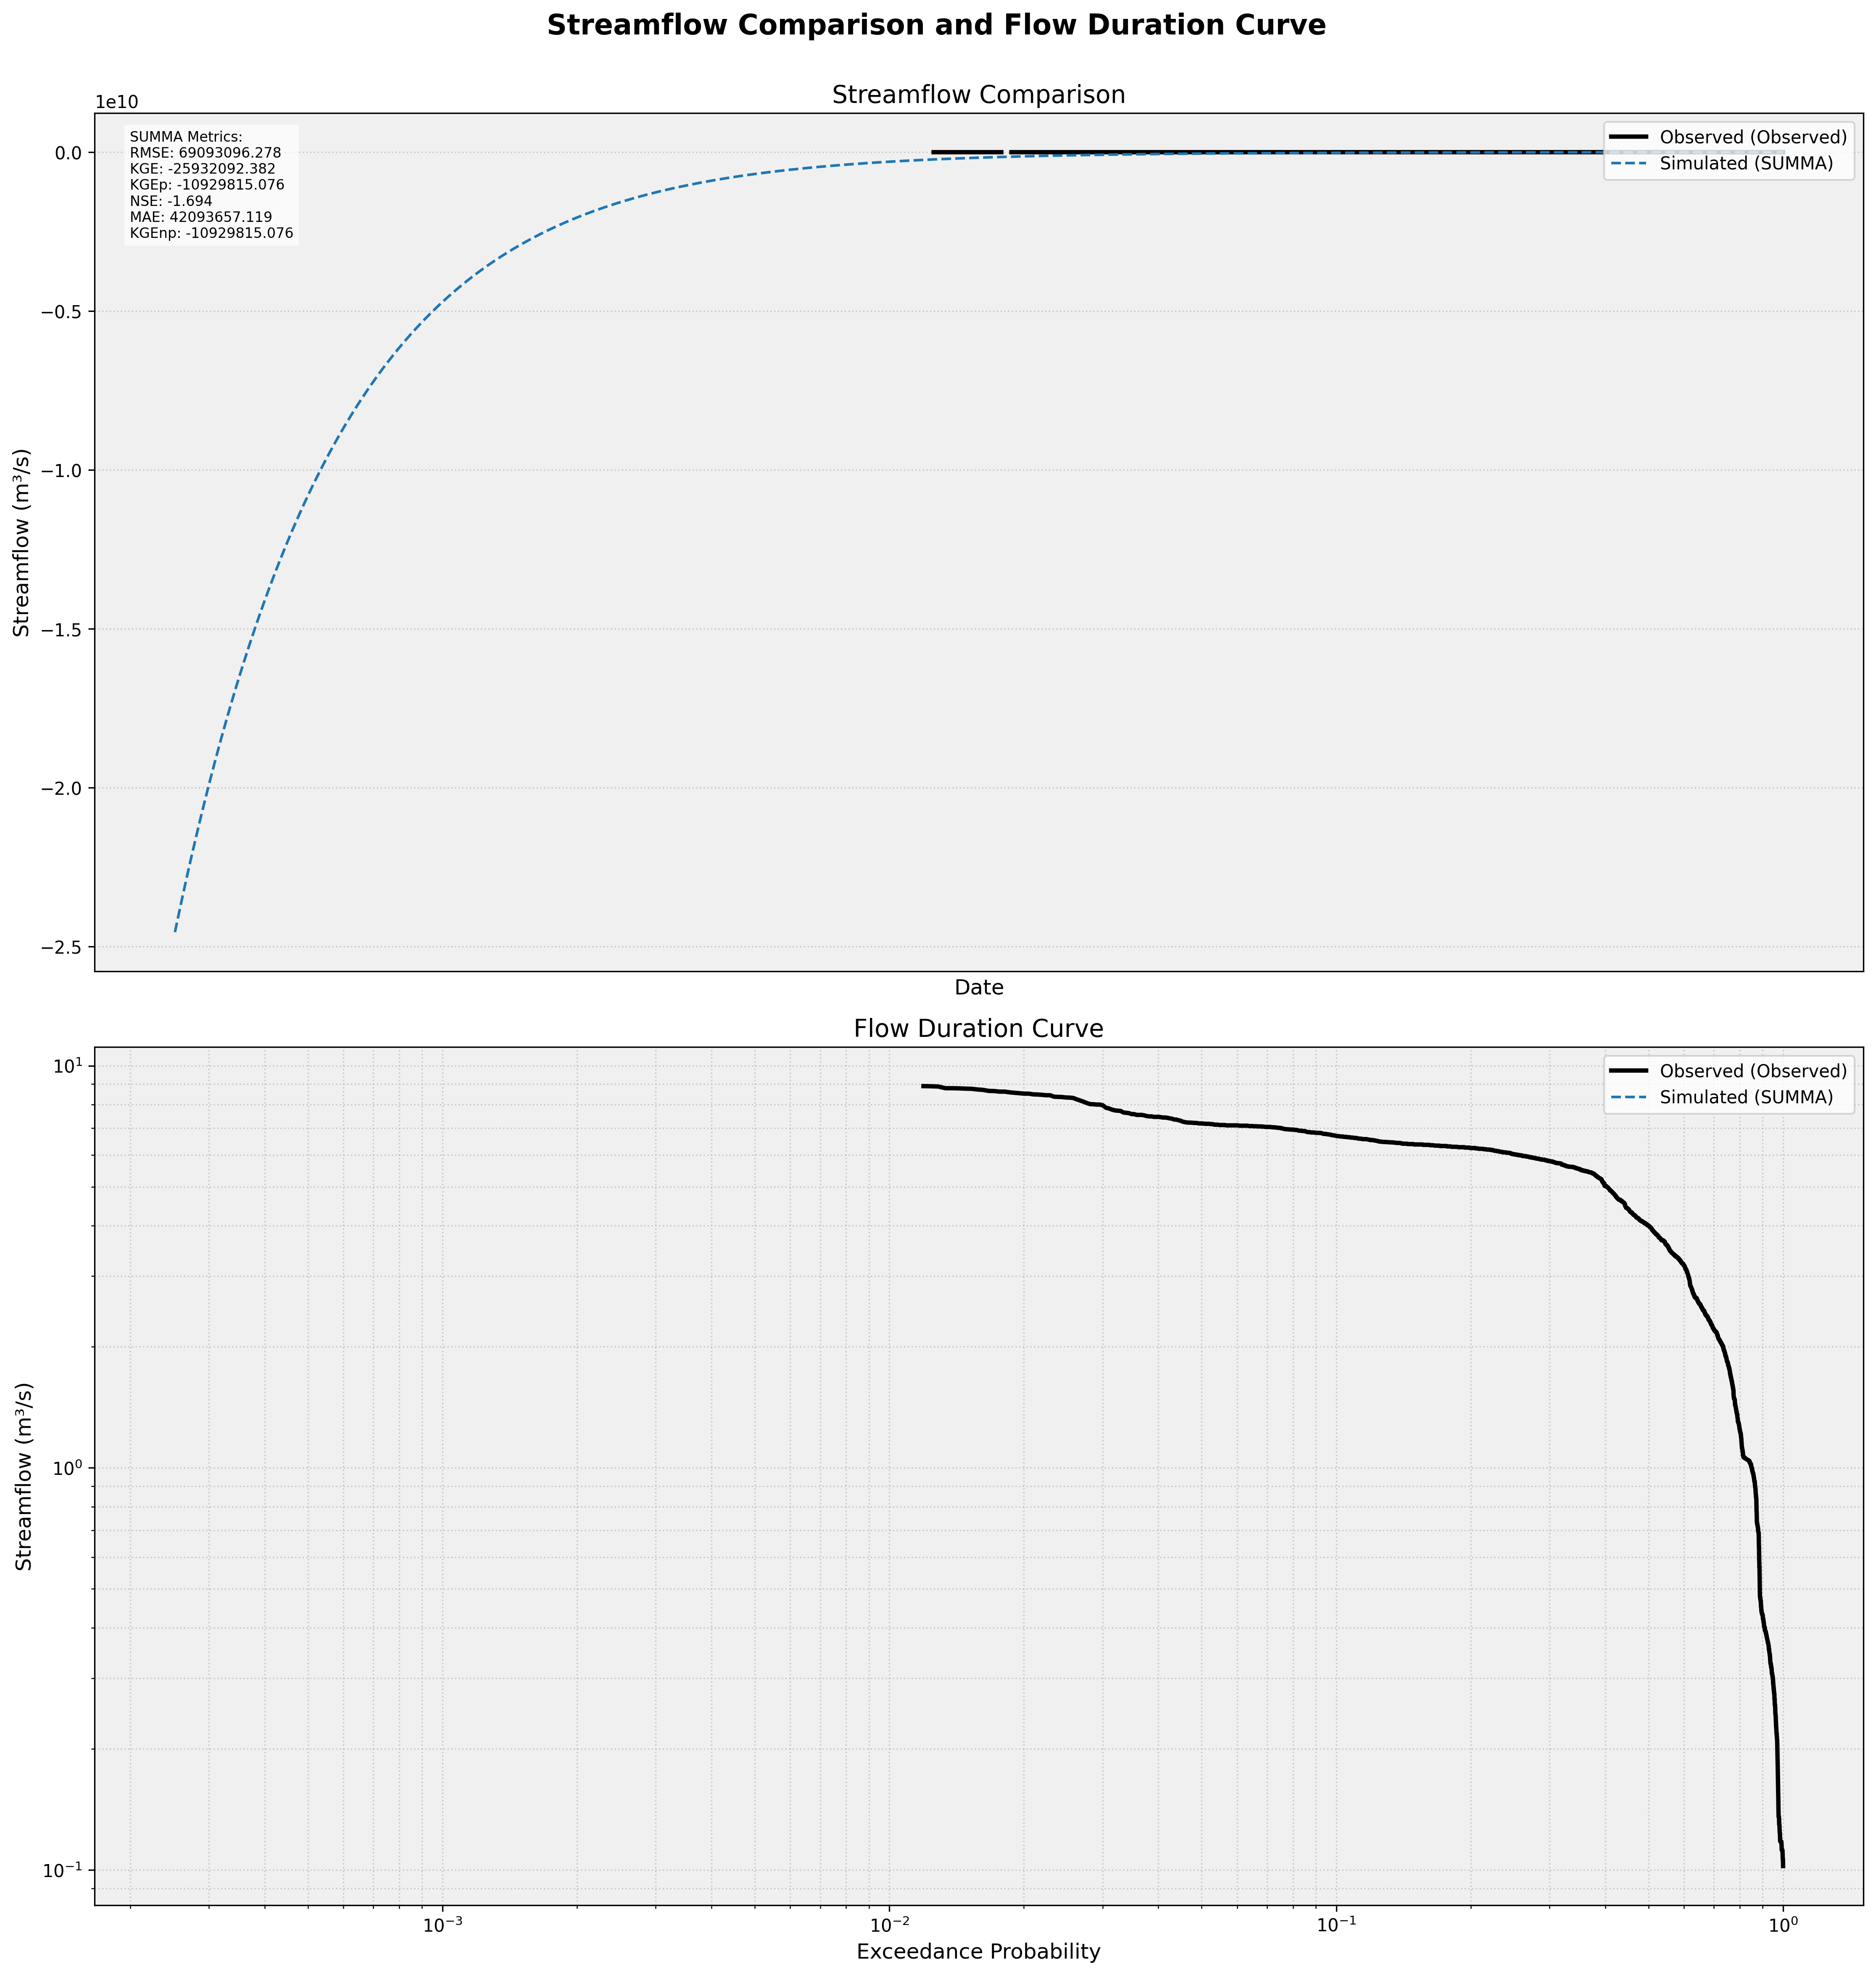

In [6]:
# Initialize time series visualizer for glacier version
vr = VisualizationReporter(config, logger)

# Create visualization
if config['DOMAIN_DEFINITION_METHOD'] != 'lumped':
    model_outputs = [(f"{config['HYDROLOGICAL_MODEL']}", str(project_dir / "simulations" / config['EXPERIMENT_ID'] / "mizuRoute" / f"{config['EXPERIMENT_ID']}.nc"))]
else: # lumped domain definition has no routing
    model_outputs = [(f"{config['HYDROLOGICAL_MODEL']}", str(project_dir / "simulations" / f"{config['EXPERIMENT_ID']}_glac" / config['HYDROLOGICAL_MODEL'] / f"{config['EXPERIMENT_ID']}_timestep.nc"))]
obs_files = [('Observed', str(project_dir / "observations" / "streamflow" / "preprocessed" / f"{config.get('DOMAIN_NAME')}_streamflow_processed.csv"))]
plot_file = vr.plot_streamflow_simulations_vs_observations(model_outputs, obs_files)

if plot_file:
    logger.info(f"Streamflow comparison plot saved to: {plot_file}")
else:
    logger.error("Failed to create streamflow comparison plot")

# Optional: Display the plot in the notebook
from IPython.display import Image
Image(filename=plot_file)
